In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-15 04:02:04 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=10,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi.value)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
    model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
#     return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
#             sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
#     return (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total) \
#             == (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma)
    return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total))\
            == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma))            
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi.value)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi.value)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = False)

In [16]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma97                  yes
                   linear_system_scaling = none                  yes
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                               ma97_umax = 0.5                   yes
                                max_iter = 500                   yes
                    max_refinement_steps = 20  

In [17]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

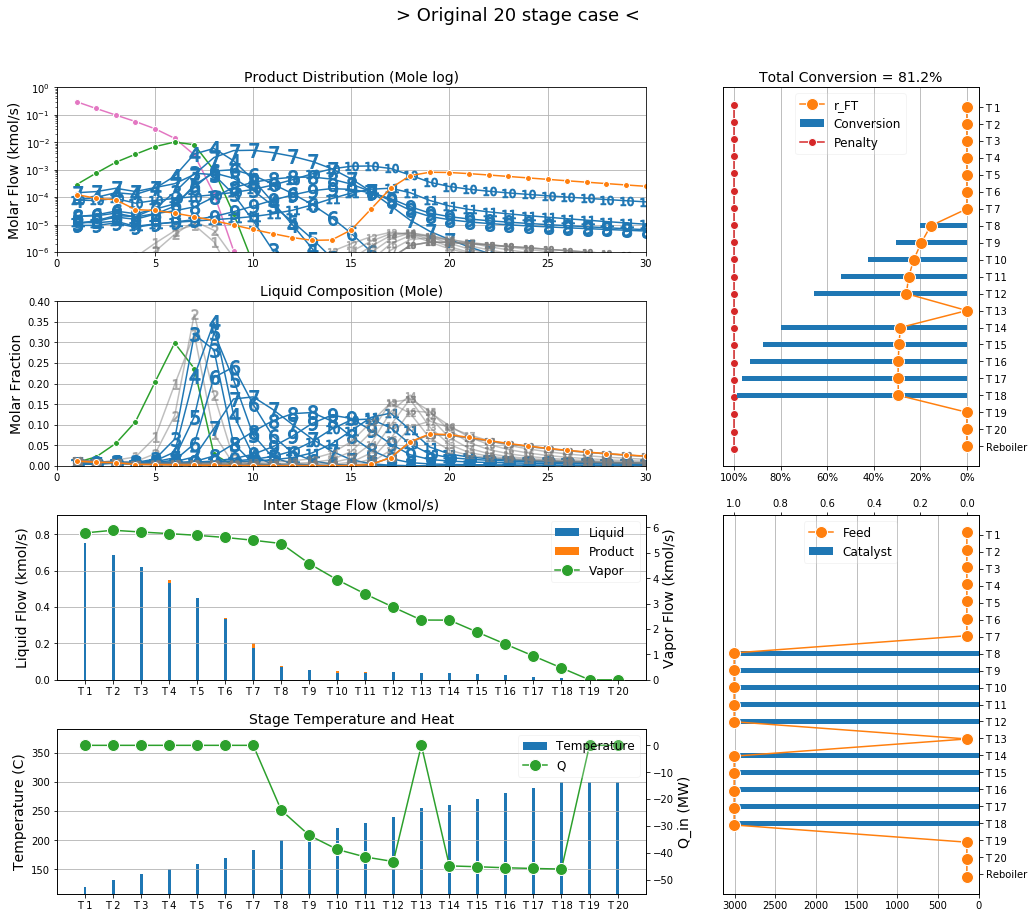

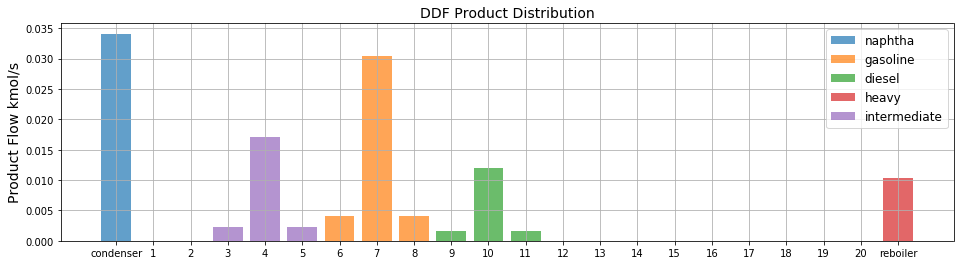

In [18]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [19]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [20]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [21]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [22]:
iter_count = 0
total_iter = 0
meta_results = {}
for i in model.component_data_objects(pe.Var,active=True):
    if i.name.count('.') <= 1:
        meta_results[i.name] = []
meta_results['iter_count'] = []
meta_results['total_iter'] = []

In [23]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = False)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model_tmp.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 2 obj 0.038973056825660435
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 4 obj 0.047987706587817834
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 6 obj 0.04974535212264567
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 8 obj 0.05337794848332779
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 10 obj 0.05339479331958003
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        

iter_count 68 total_iter 68 obj 0.10227154878299863
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 70 obj 0.10028467251450325
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 72 obj 0.10193628693334403
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 74 obj 0.10227264998861146
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 76 obj 0.10176368943333074
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 78 obj 0.10218684601544441
iter_count 80 total_iter 80 obj 0.10235739630792075



> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.03%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1386          0.9921  0.0871       2.3285

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.7  0.000       0.000  0.000  0.000  0.000       5.5466  0.0000  1.2312  0.0000       20.000
NON--[2]     149.7  0.000       0.000  0.000  0.000  0.000       5.7857  0.0000  1.1758  0.0000       20.000
NON--[3]     160.9  0.000       0.000  0.000  0.000  0.000       5.7303  0.0000  1.1268  0.0000       20.000
NON--[4]     170.0  0.00

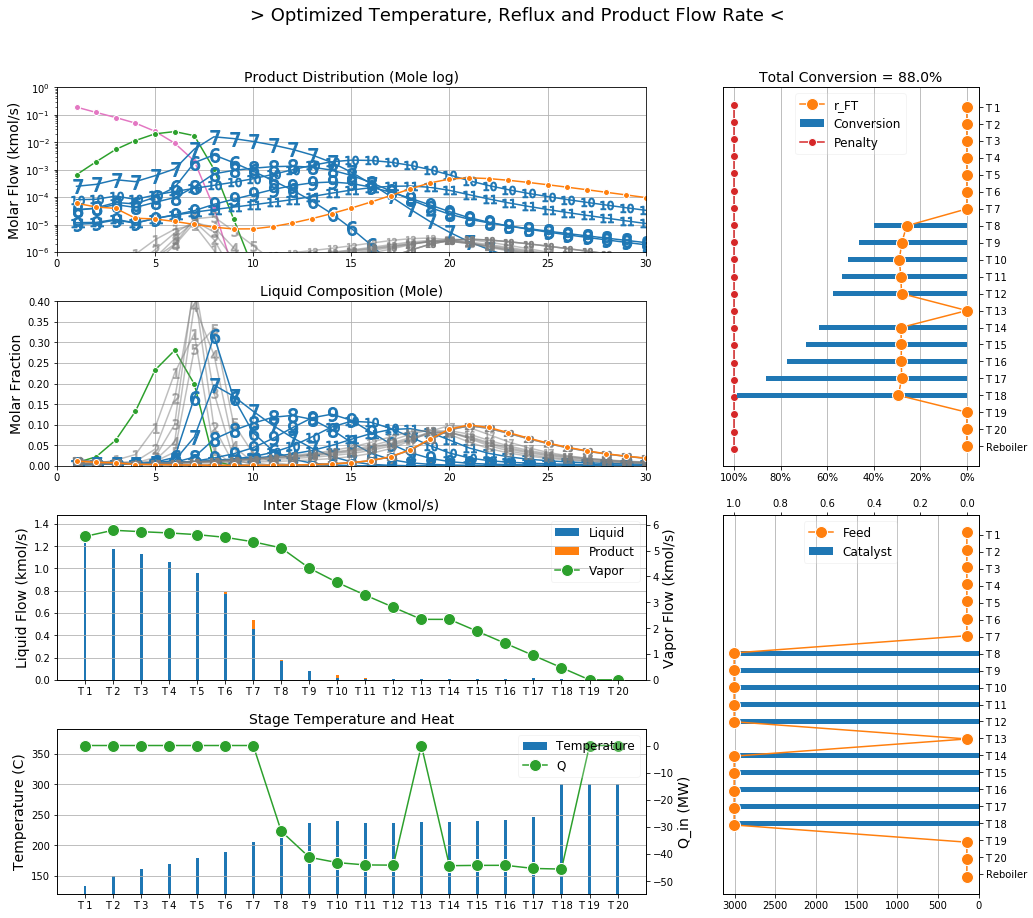

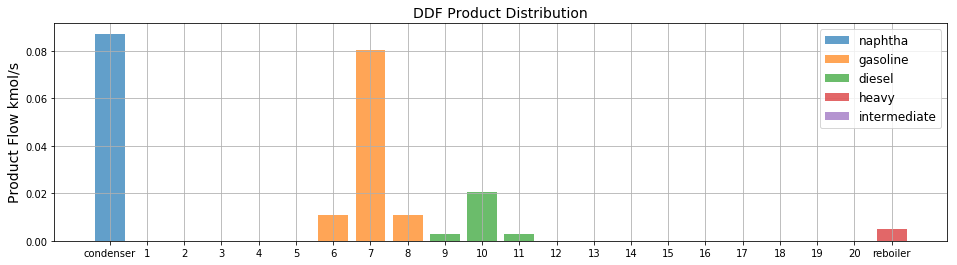

In [24]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [25]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [26]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [27]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Gasoline Location')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     # check_iteration()

# plot_distribution(model,pdf,'Optimized Gasoline Location')
# plot_product_distribution(model,pdf)

In [28]:
# master_model = deepcopy(model)

In [29]:
# model = deepcopy(master_model)

In [30]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(7)
model.N_tray['diesel'].setub(20)

In [31]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = False)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model_tmp.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 82 obj 0.10235739752705063
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 84 obj 0.10235800292484899
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 86 obj 0.10241448844207816
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 88 obj 0.10302173747647624
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 90 obj 0.10350712199851968
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
      

iter_count 68 total_iter 148 obj 0.10932403757497906
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 150 obj 0.1096299807613321
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 152 obj 0.10953797746177577
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 154 obj 0.10953601256306325
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 156 obj 0.1095371830706658
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 158 obj 0.10953708127098569
iter_count 80 total_iter 160 obj 0.10953708057546793



> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 87.74%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -154.                                        2.0987          0.8402  0.0820       2.3344

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     128.5  0.000       0.000  0.000  0.000  0.000       5.3555  0.0000  1.0040  0.0000       20.000
NON--[2]     142.5  0.000       0.000  0.000  0.000  0.000       5.5193  0.0000  0.9182  0.0000       20.000
NON--[3]     154.4  0.000       0.000  0.000  0.000  0.000       5.4335  0.0000  0.8276  0.0000       20.000
NON--[4]     166.8  0.000       0.000  0.000  0.00

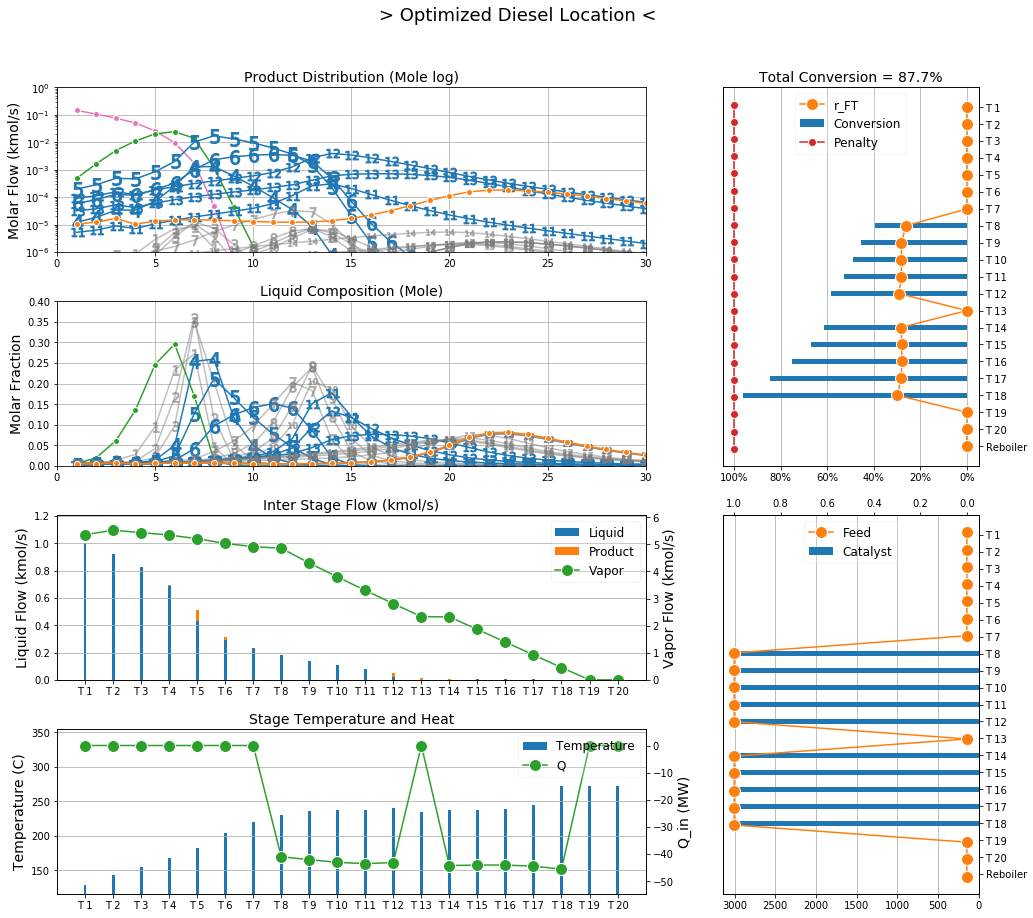

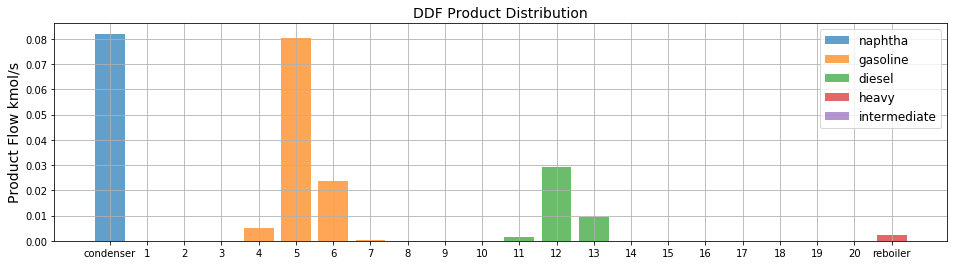

In [32]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [33]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [34]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(1e-5)
    model.reactive[j].F.setub(10)
    
# soft constraints to guide the feed allocation pattern
model.reactive[17].F.setlb(3)

In [35]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [36]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Feed Allocation')
#     print('-'*108)
#     beautify(pe,model)
#     check_product_spec(model)
#     log_now()
#     check_iteration()

# plot_distribution(model,pdf,'Optimized Feed Allocation')
# plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [37]:
for j in model.TRAY_reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(10)
    model.reactive[j].cat.setub(30000)

In [38]:
model.total_cat_con = pe.ConstraintList()
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [39]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = False)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model_tmp.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 162 obj 0.10953675515527134
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 164 obj 0.10918444885862168
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 166 obj 0.1091175839732391
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 168 obj 0.1099232994667921
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 170 obj 0.11113144325502847
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
   

iter_count 68 total_iter 228 obj 0.12414668882052844
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 230 obj 0.12807487320608493
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 232 obj 0.12322674797293202
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 234 obj 0.13109225624891532
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 236 obj 0.12602673146373566
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 238 obj 0.13133091380214534
    model=reactive_distillation;
        message fro

iter_count 136 total_iter 296 obj 0.13773269241565927
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 138 total_iter 298 obj 0.1367052889568531
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 140 total_iter 300 obj 0.13424267824436328
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 142 total_iter 302 obj 0.13760074601886665
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 144 total_iter 304 obj 0.13761329079810047
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 146 total_iter 306 obj 0.1347599136741578
    model=reactive_distillation;
        message

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 204 total_iter 364 obj -4.47357079857306
iter_count 206 total_iter 366 obj 0.14008836284466122



> Optimized Catalyst Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.99%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -149.                                        1.7259          0.6052  0.0819       2.4668

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.5  0.000       0.000  0.000  0.000  0.000       4.8799  0.0000  0.6993  0.0000       20.000
NON--[2]     131.0  0.000       0.000  0.000  0.000  0.000       4.9740  0.0000  0.6289  0.0000       20.000
NON--[3]     140.0  0.000       0.000  0.000  0.000  0.000       4.9036  0.0000  0.5578  0.0000       20.000
NON--[4]     150.7  0.000       0.000

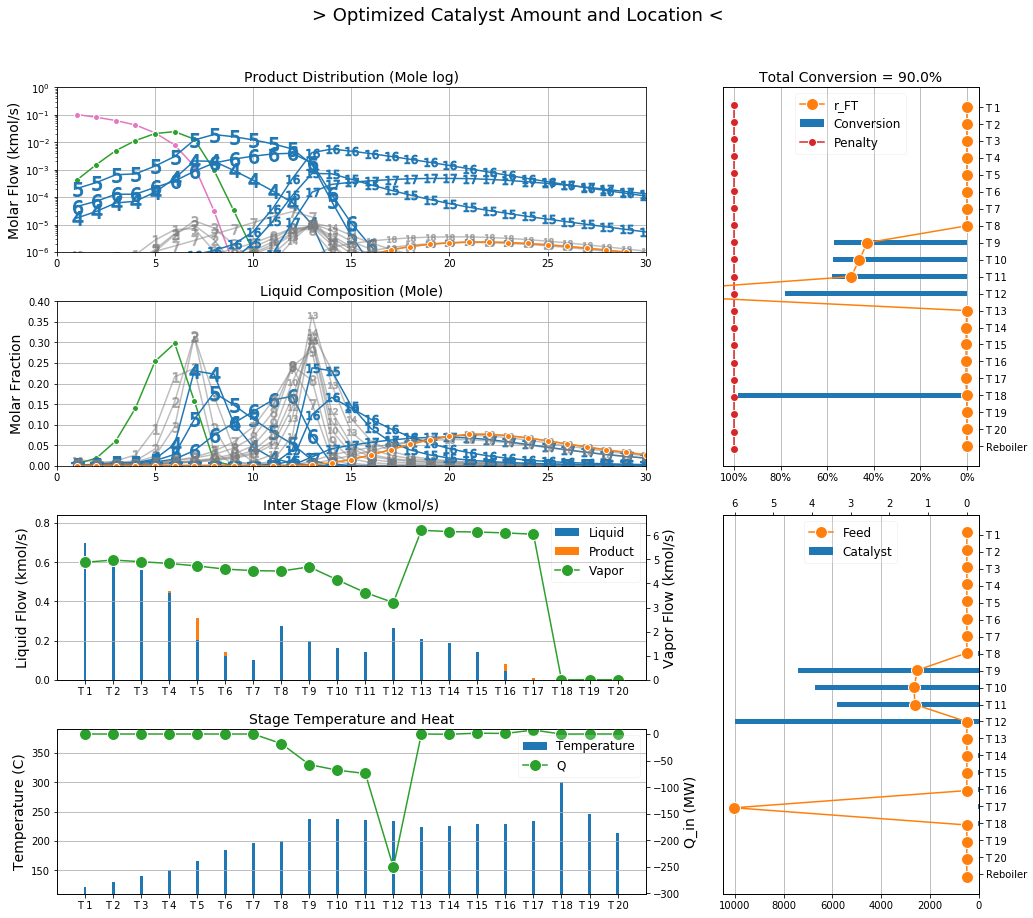

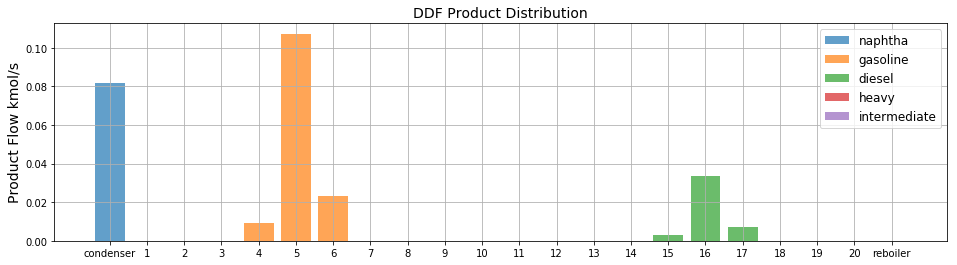

In [40]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Catalyst Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    # check_iteration()

plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
plot_product_distribution(model,pdf)

In [41]:
pdf.close()

In [42]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)

In [43]:
with open('./log/results/{}.pickle'.format(logname),'wb') as f:
    pickle.dump(meta_results,f,protocol=pickle.HIGHEST_PROTOCOL)